In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
uploaded = files.upload()

Saving ai_tutor_dataset_1000.csv to ai_tutor_dataset_1000.csv


In [ ]:
import io
data=pd.read_csv(io.BytesIO(uploaded['ai_tutor_dataset_1000.csv']))
data.head()

,Name,Age,Gender,Country,State,City,Parent Occupation,Earning Class,Level of Student,Level of Course,Course Name,Assessment Score,Time spent Per Day,Material Level,IQ of Student
0,Jacqueline Wilson,14,Male,Canada,Ontario,Toronto,Scientist,Low,Advanced,Basic,Geography,50.18,2.87,Medium,127
1,William Wilson,18,Male,USA,New York,New York City,Scientist,Low,Beginner,Intermediate,Biology,58.44,1.72,Medium,89
2,Sophia Davis,12,Female,Australia,New South Wales,Sydney,Doctor,Middle,Beginner,Advanced,Geography,93.74,0.51,Easy,104
3,William Davis,16,Male,India,Maharashtra,Pune,Teacher,High,Beginner,Intermediate,Chemistry,54.78,1.53,Hard,99
4,Stephanie Tapia,5,Male,USA,Texas,Houston,Engineer,High,Beginner,Intermediate,Biology,49.34,2.75,Hard,124


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                1000 non-null   object 
 1   Age                 1000 non-null   int64  
 2   Gender              1000 non-null   object 
 3   Country             1000 non-null   object 
 4   State               1000 non-null   object 
 5   City                1000 non-null   object 
 6   Parent Occupation   1000 non-null   object 
 7   Earning Class       1000 non-null   object 
 8   Level of Student    1000 non-null   object 
 9   Level of Course     1000 non-null   object 
 10  Course Name         1000 non-null   object 
 11  Assessment Score    1000 non-null   float64
 12  Time spent Per Day  1000 non-null   float64
 13  Material Level      1000 non-null   object 
 14  IQ of Student       1000 non-null   int64  
dtypes: float64(2), int64(2), object(11)
memory usage: 117.3+

In [ ]:
data.describe()

,Age,Assessment Score,Time spent Per Day,IQ of Student
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,10.883000,70.513160,1.757400,110.390000
std,4.286921,17.047225,0.730947,17.345396
min,4.000000,40.110000,0.500000,80.000000
25%,7.000000,56.702500,1.130000,96.000000
50%,11.000000,70.840000,1.780000,110.000000
75%,15.000000,85.182500,2.372500,126.000000
max,18.000000,100.000000,3.000000,140.000000


In [ ]:
data.isnull().sum()

,0
Name,0
Age,0
Gender,0
Country,0
State,0
City,0
Parent Occupation,0
Earning Class,0
Level of Student,0
Level of Course,0


In [ ]:
data.duplicated().sum()

0

**UNIVARIATE ANALYSIS**

<Axes: >

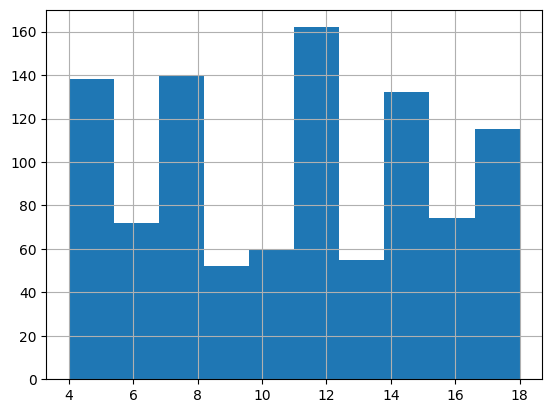

In [ ]:
data["Age"].hist(bins=10)

<Axes: >

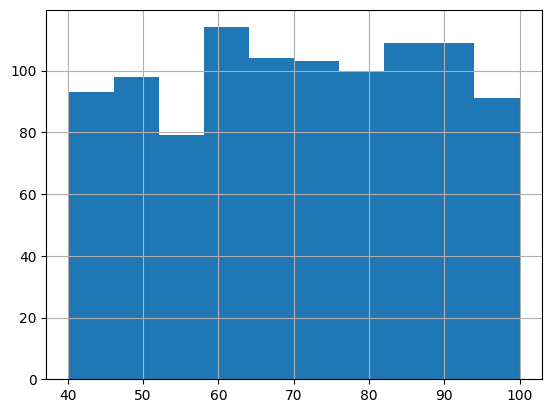

In [ ]:
data["Assessment Score"].hist(bins=10)

<Axes: >

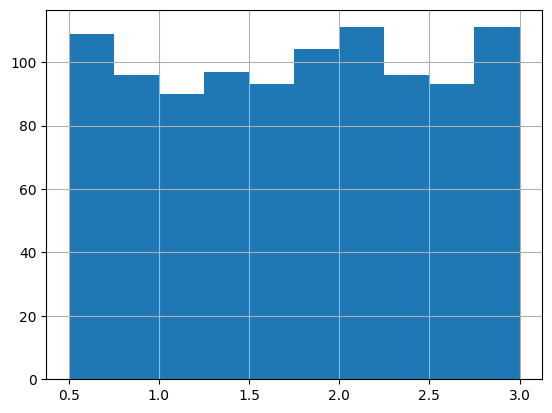

In [ ]:
data["Time spent Per Day"].hist(bins=10)

<Axes: xlabel='IQ of Student'>

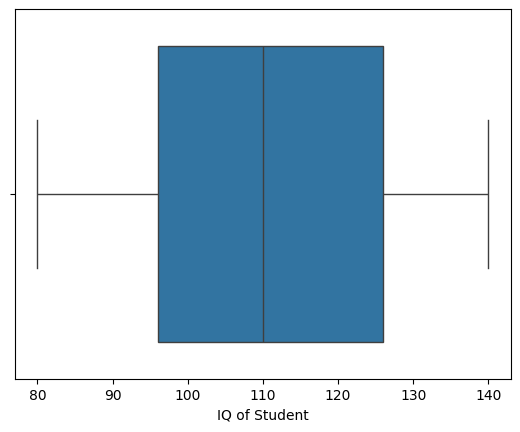

In [ ]:
sns.boxplot(x=data["IQ of Student"])

<Axes: xlabel='Age'>

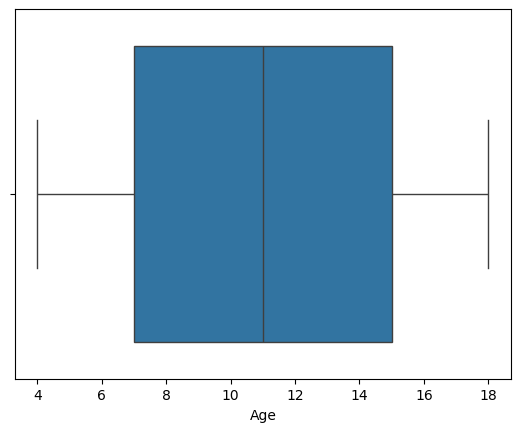

In [ ]:
sns.boxplot(x=data["Age"])


Gender
Male                 500
Female               470
Prefer not to say     30
Name: count, dtype: int64


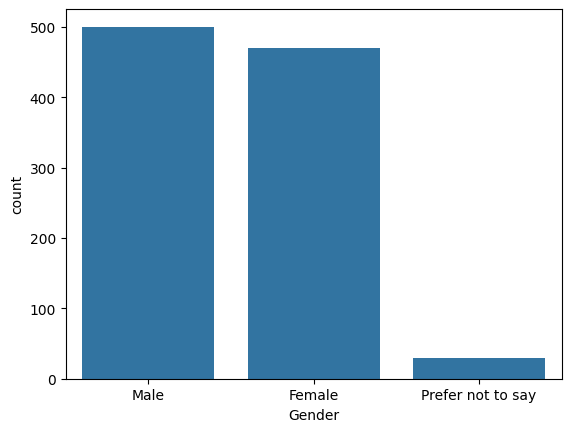

In [ ]:
#  analyse the gender

import matplotlib.pyplot as plt
# Analyze Gender
print(data['Gender'].value_counts())
sns.countplot(x='Gender', data=data)
plt.show()




In [ ]:
# Outlier detection using Z-score
from scipy.stats import zscore
numerical_cols = data.select_dtypes(include=['number']).columns
z_scores = np.abs(zscore(data[numerical_cols].dropna()))
outliers = (z_scores > 3).sum(axis=0)
print("\nOutliers Detected (Z-score > 3):")
print(outliers)


Outliers Detected (Z-score > 3):
Age                   0
Assessment Score      0
Time spent Per Day    0
IQ of Student         0
dtype: int64


**GOAL 1: DECIDING WHETHER THE STUDENT SHOULD BE PROMOTED TO THE NEXT LEVEL OR NOT**

In [ ]:
# Define weightages for complexity factors
weights = {
    "Assessment Score": 0.5,  # Major factor
    "Time spent Per Day": 0.2,  # Engagement level
    "IQ of Student": 0.1,  # Cognitive ability
    "Material Level": 0.1,  # Difficulty of learning material
    "Course Difficulty Mismatch": 0.1  # Student level vs Course level
}

In [ ]:
# Normalize material level to numerical values
material_mapping = {"Easy": 1, "Medium": 2, "Hard": 3}
data["Material Level Numeric"] = data["Material Level"].map(material_mapping)

In [ ]:
# Define course level mapping
course_mapping = {"Basic": 1, "Intermediate": 2, "Advanced": 3}
student_mapping = {"Beginner": 1, "Intermediate": 2, "Advanced": 3}

In [ ]:
data["Course Level Numeric"] = data["Level of Course"].map(course_mapping)
data["Student Level Numeric"] = data["Level of Student"].map(student_mapping)

In [ ]:
# Calculate mismatch penalty (if a student is taking a harder course than their level)
data["Course Difficulty Mismatch"] = np.abs(data["Course Level Numeric"] - data["Student Level Numeric"])

In [ ]:
# Compute Promotion Score using weighted sum
data["Promotion Score"] = (
    data["Assessment Score"] * weights["Assessment Score"] +
    data["Time spent Per Day"] * weights["Time spent Per Day"] * 20 +  # Scale up time spent
    data["IQ of Student"] * weights["IQ of Student"] / 140 * 100 +  # Normalize IQ (assuming max 140)
    data["Material Level Numeric"] * weights["Material Level"] * 30 +  # Scale material difficulty
    data["Course Difficulty Mismatch"] * weights["Course Difficulty Mismatch"] * -20  # Deduct for mismatch
)

# Define a new promotion threshold (scaled based on complexity)
data["Promoted"] = (data["Promotion Score"] >= 60).astype(int)

# Train-test split for model training with new complexity factors
features = ["Assessment Score", "Time spent Per Day", "IQ of Student",
            "Material Level Numeric", "Course Difficulty Mismatch"]
X_complex = data[features]
y_complex = data["Promoted"]

# Import train_test_split
from sklearn.model_selection import train_test_split

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_complex, y_complex, test_size=0.2, random_state=42)

# Train a classification model (RandomForestClassifier for better decision-making)
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_c, y_train_c)

# Predictions and evaluation
y_pred_c = clf.predict(X_test_c)
#Import accuracy_score
from sklearn.metrics import accuracy_score
accuracy_complex = accuracy_score(y_test_c, y_pred_c)

accuracy_complex

0.96

In [ ]:
def check_promotion(student_name):
    # Find the student in the dataset
    student = data[data["Name"] == student_name]

    if student.empty:
        return f"Student '{student_name}' not found in the dataset."

    # Extract required features for prediction
    student_features = student[["Assessment Score", "Time spent Per Day", "IQ of Student",
                                "Material Level Numeric", "Course Difficulty Mismatch"]]

    # Predict promotion status
    prediction = clf.predict(student_features)[0]

    # Return result
    return f"Student '{student_name}' will be {'Promoted' if prediction == 1 else 'Not Promoted'}."

# Example usage (Replace with actual name from dataset)
example_student = data["Name"].sample(1).values[0]
check_promotion(example_student)


"Student 'Emily Sanchez' will be Not Promoted."